In [20]:
import numpy as np
try:
    import pyaudio
except:
    !pip3 install pyaudio
    import pyaudio

import wave
import time

try:
    import librosa, librosa.display
except:
    !pip3 install librosa
    import librosa, librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

In [21]:
FORMAT = pyaudio.paInt16
#FORMAT = pyaudio.paFloat32
CHANNELS = 1
RATE = 44100
CHUNK = 512
RECORD_SECONDS = 20
WAVE_OUTPUT_FILENAME = "recordedFile.wav"
device_index = 2
audio = pyaudio.PyAudio()

In [22]:
print("----------------------record device list---------------------")
info = audio.get_host_api_info_by_index(0)
numdevices = info.get('deviceCount')
for i in range(0, numdevices):
        if (audio.get_device_info_by_host_api_device_index(0, i).get('maxInputChannels')) > 0:
            print("Input Device id ", i, " - ", audio.get_device_info_by_host_api_device_index(0, i).get('name'))

print("-------------------------------------------------------------")

----------------------record device list---------------------
Input Device id  0  -  MacBook Pro Microphone
Input Device id  2  -  Microsoft Teams Audio
-------------------------------------------------------------


In [23]:
#index = int(input())
index = 0
print("recording via index "+str(index))

recording via index 0


In [24]:
stream = audio.open(format=FORMAT, channels=CHANNELS,
                rate=RATE, input=True, input_device_index = index,
                frames_per_buffer=CHUNK)
print ("recording started")
Recordframes = []

import struct

start = time.time()
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK, exception_on_overflow = False)
    Recordframes.append(data)
    if (i%100 == 0):
        print(f"{time.time() - start:.1f} ",  end = '')
tf = time.time() - start
print ("recording stopped")

signal = np.hstack(Recordframes)

stream.stop_stream()
stream.close()
audio.terminate()

recording started
0.0 1.2 2.3 3.5 4.7 5.8 7.0 8.2 9.3 10.5 11.6 12.8 14.0 15.1 16.3 17.4 18.6 19.8 recording stopped


In [25]:
waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
waveFile.setnchannels(CHANNELS)
waveFile.setsampwidth(audio.get_sample_size(FORMAT))
waveFile.setframerate(RATE)
waveFile.writeframes(b''.join(Recordframes))
waveFile.close()

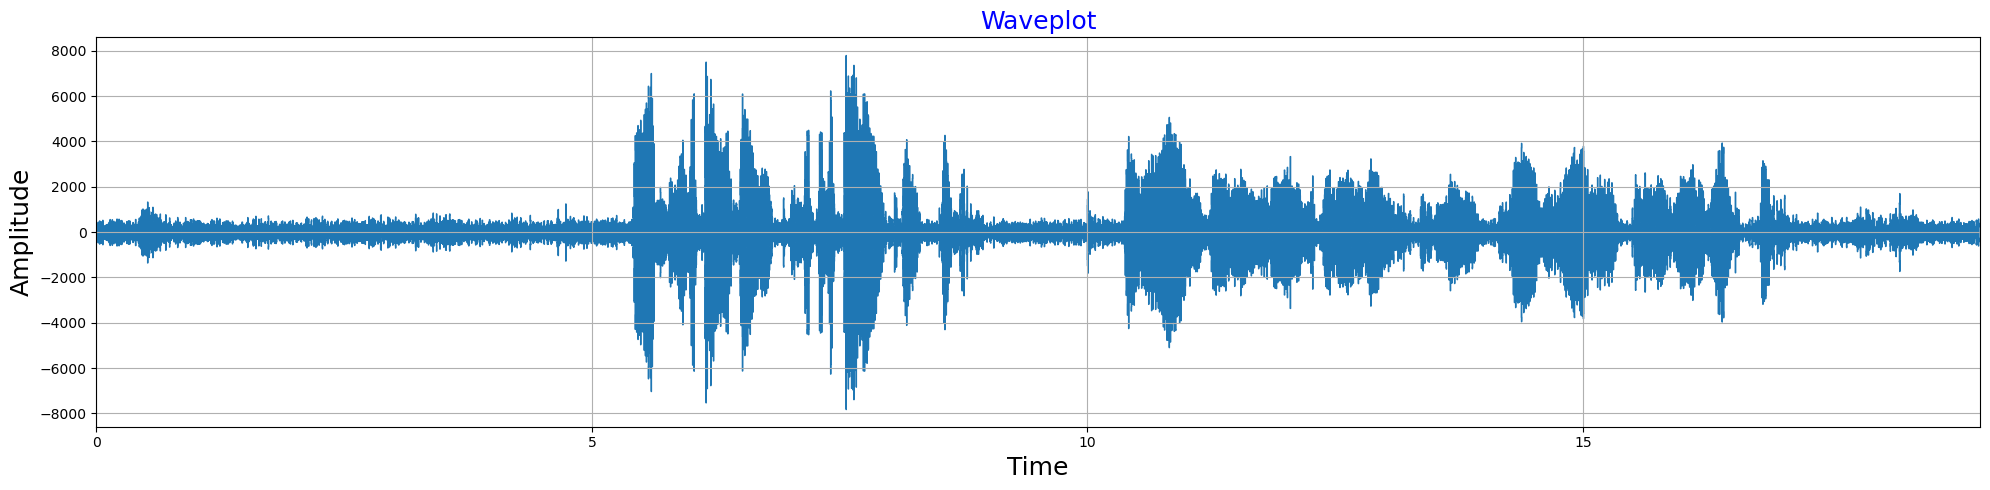

In [26]:
signal_f = np.frombuffer(signal, dtype='int16').astype('float32')
plt.figure(figsize=(20, 5))
t_ignore = 1
librosa.display.waveshow(signal_f[t_ignore*RATE:], sr=RATE)
plt.title('Waveplot', fontdict=dict(size=18))
plt.xlabel('Time', fontdict=dict(size=18))
plt.ylabel('Amplitude', fontdict=dict(size=18))
plt.xlim(0,tf-t_ignore)
plt.savefig('./data/mic_recorder_0.png', bbox_inches='tight', dpi=300)
plt.show()

In [27]:
from scipy import signal
from scipy.fft import fft, fftfreq, fftshift, ifft
from scipy.signal import blackman

y = signal_f[t_ignore*RATE:]
y = y/max(y)
N = len(y)
fs = RATE
T = N/fs
t = np.arange(N)*T/N

def nicegrid(ax=plt):
    ax.grid(True, which='major', color='#666666', linestyle=':')
    ax.grid(True, which='minor', color='#999999', linestyle=':', alpha=0.2)
    ax.minorticks_on()

In [28]:
Y_fft = fft(y)
f_bl = fftfreq(N, 1/fs)

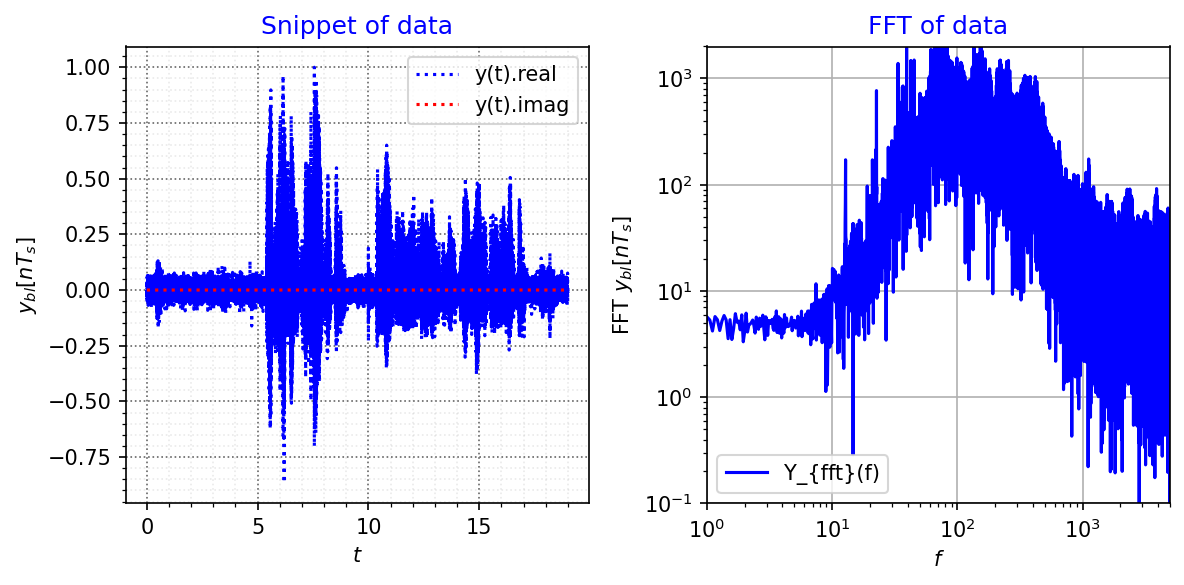

In [41]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4), dpi=150)
fig.tight_layout(pad=2)
ax1.plot(t, y.real, 'b:', t, y.imag, 'r:')
ax1.set_ylabel('$y_{bl}[nT_s]$')
ax1.set_xlabel('$t$')
ax2.set_xlim([0, 19])
ax1.legend(['y(t).real','y(t).imag'])
ax1.set_title('Snippet of data')
nicegrid(ax1)

ax2.loglog(f_bl[0:N//2], np.abs(Y_fft[0:N//2]),'b-')
ax2.set_ylabel('FFT $y_{bl}[nT_s]$')
ax2.set_xlabel('$f$')
ax2.set_xlim([10, 5000])
ax2.set_ylim([.1, 2000])
ax2.legend(['Y_{fft}(f)','Y_{given}(f)'])
ax2.set_title('FFT of data')
plt.show()

In [82]:
delta_freq = fs/N

# bounds of rect in Y(f)
f_low = 200
f_high = 20000
# find equivalent positions in Y(f) 
n_low = int(f_low/delta_freq)
n_high = int(f_high/delta_freq)
L1 = np.arange(n_low,n_high)

Y_n = np.zeros((N,), dtype=complex)
# create random phase needed for correct ifft process
rng = np.random.default_rng()
phi = rng.uniform(0, 2*np.pi, (len(L1),))

# create Y(f)
if (0):
    mag_temp = np.sin(np.pi*np.arange(0,n_high-n_low)/(n_high-n_low))
else:
    mag_temp = 850*np.ones([1,n_high-n_low])
    
Y_n[L1] = mag_temp*np.exp(1j*phi)
# add complex conjugate at upper end to ensure that y[n] real
Y_n[N-L1] = np.conj(Y_n[L1])

# create y[n]
noise = ifft(Y_n)

In [83]:
yn = y + noise.real
Y_fft_n = fft(yn)

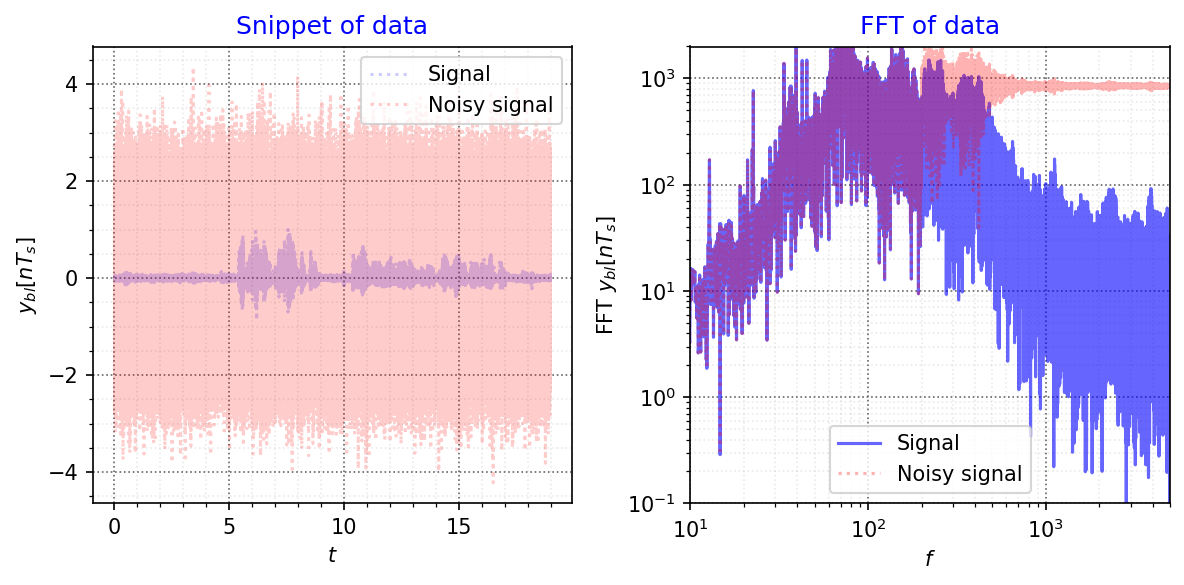

In [91]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4), dpi=150)
fig.tight_layout(pad=2)
ax1.plot(t, y, 'b:', t, yn, 'r:',alpha=0.2)
ax1.set_ylabel('$y_{bl}[nT_s]$')
ax1.set_xlabel('$t$')
ax1.legend(['Signal','Noisy signal'])
ax2.set_xlim([0, 19])
ax1.set_title('Snippet of data')
nicegrid(ax1)

ax2.loglog(f_bl[0:N//2], np.abs(Y_fft[0:N//2]),'b-',alpha=0.6)
ax2.loglog(f_bl[0:N//2], np.abs(Y_fft_n[0:N//2]),'r:',alpha=0.3)
ax2.set_ylabel('FFT $y_{bl}[nT_s]$')
ax2.set_xlabel('$f$')
ax2.set_xlim([10, 5000])
ax2.set_ylim([.1, 2000])
ax2.legend(['Signal','Noisy signal'])
ax2.set_title('FFT of data')
nicegrid(ax2)
plt.show()

In [88]:
# Low Pass
b_low, a_low = signal.butter(2, 200, 'low', fs=fs)
f_low, h_low = signal.freqz(b_low, a_low,fs=fs,worN=1000)
yn_lp = signal.lfilter(b_low, a_low, yn)
Yn_lp_fft = fft(yn_lp)

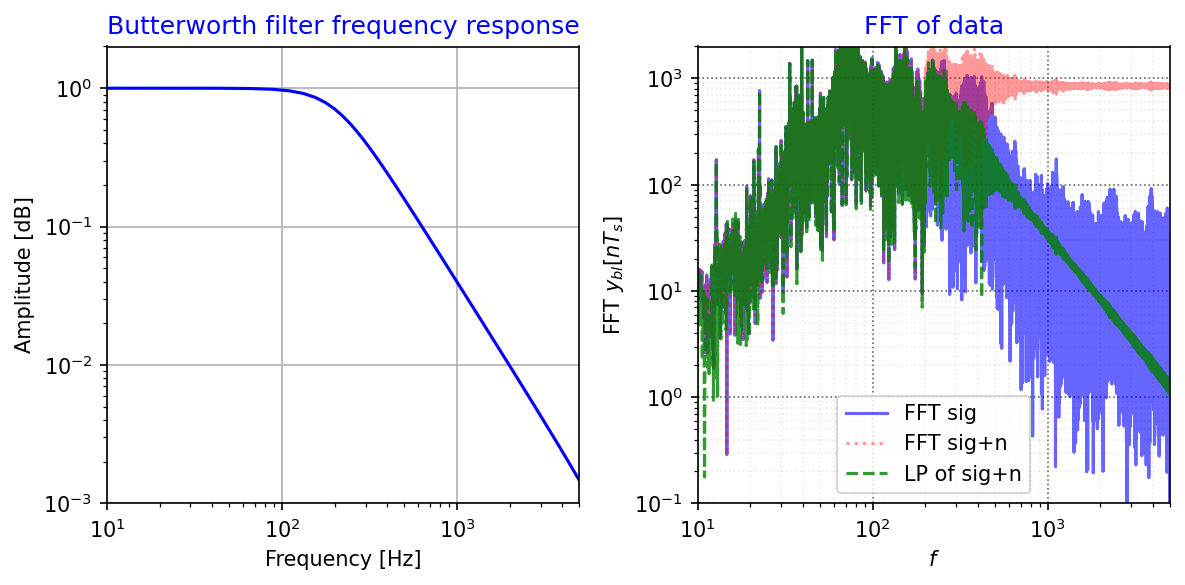

In [89]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4), dpi=150)
eps = 1e-12
ax1.loglog(f_low, abs(h_low+eps),'b-',label='LP')
ax1.set_title('Butterworth filter frequency response')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Amplitude')
ax1.set_xlim([10, 5000])
ax1.set_ylim([.001, 2])
nicegrid()

ax2.loglog(f_bl[0:N//2], np.abs(Y_fft[0:N//2]),'b-',alpha=0.6)
ax2.loglog(f_bl[0:N//2], np.abs(Y_fft_n[0:N//2]),'r:',alpha=0.4)
ax2.loglog(f_bl[0:N//2], np.abs(Yn_lp_fft[0:N//2]),'g--',alpha = .8)
ax2.set_ylabel('FFT $y_{bl}[nT_s]$')
ax2.set_xlabel('$f$')
ax2.set_xlim([10, 5000])
ax2.set_ylim([.1, 2000])
ax2.legend(['FFT sig','FFT sig+n','LP of sig+n'])
ax2.set_title('FFT of data')
plt.show()

In [90]:
from scipy.io.wavfile import write
y_norm = y/max(abs(y))
write("data/example.wav", RATE, y_norm.astype(np.float32))
yn_norm = yn/max(abs(yn))
write("data/example_noisy.wav", RATE, yn_norm.astype(np.float32))
yn_lp_norm = yn/max(abs(yn_lp))
write("data/example_noisy_lp.wav", RATE, yn_lp_norm.astype(np.float32))